<a href="https://colab.research.google.com/github/aitorer/Entrega-Pr-cticas-/blob/main/Copia_de_TADM2022_S04_Razonamiento_Aproximado_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Vamos a operar de diferentes maneras con los préstamos de nuestro banco, en concreto vamos a intentar crear clasificadores para que dadas unas variables nos den la probabilidad o el rating de darle un préstamo a un cliente

## Carga de Datos

In [ ]:
!gdown --id 1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Osmr7qVN0NMuqYxvLesNn7H4nqPCVbsU
To: /content/data_berka.db
100% 70.2M/70.2M [00:00<00:00, 161MB/s]


1. Cargamos la extensión sql

In [ ]:
%load_ext sql

2. Nos conectamos con la base de datos

In [ ]:
%sql sqlite:///data_berka.db

'Connected: @data_berka.db'

> Datos de préstamos ya finalizados con su estado final, incluyendo datos del distrito, etc.

¿Cuántos préstamos hay por cada estado (status)?

In [ ]:
%%sql
SELECT status, count(*) as total
FROM loan
GROUP BY status
ORDER BY total DESC



 * sqlite:///data_berka.db
Done.


status,total
C,403
A,203
D,45
B,31


Vamos a empezar obteniendo los datos de los préstamos ya finalizados. Van a ser nuestros datos de entrenamiento. Por lo que seleccionaremos únicamente aquellos préstamos en status 'A' o 'B'. 

Con una sentencia CASE vamos a poner los prestamos finalizados bien a 1 y los que no finalizaron bien a 0. 

Sintaxis de uso de [INNER JOIN](https://www.sqlitetutorial.net/sqlite-inner-join/) para establecer joins entre tablas

Con account obtenemos los datos demograficos, realizamos el join entre account y loan y le decimos que nos muestre los prestamos que esten en estado A o B

La primera linea se utiliza para meter todo en loans_train

Otra medida es INNER JOIN mediante FROM

Con CASE se pueden establecer diferentes valores de salida, por ejemplo en este caso cuando sea A, nos saldrá un 1 o si es B saldrá 0. Con else podemos crear un valor alternativo

In [ ]:
%%sql loans_train << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'A' THEN 1
              WHEN 'B' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("A", "B")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_train


3. Obtenemos el DataFrame

In [ ]:
df_train = loans_train.DataFrame()
df_train.head()

,year,amount,duration,payments,A11,A13,label
0,93,96396,12,8033,9650,3.67,0
1,93,165960,36,4610,8369,2.31,1
2,93,127080,60,2118,8390,2.89,1
3,93,105804,36,2939,8754,4.31,1
4,93,274740,60,4579,12541,0.43,1


In [ ]:
df_train.shape

(234, 7)

Para la parte de *test* lo que vamos a extraer de la Base de Datos son los préstamos que están en ejecución (`status in ("C", "D")`) con los mismos campos que en la consulta anterior.

In [ ]:
%%sql loans_test << SELECT substr(l.date,0,3) year, amount, duration, payments, A11, A13,
  CASE status WHEN 'C' THEN 1
              WHEN 'D' THEN 0
  END label
  FROM LOAN l, ACCOUNT a INNER JOIN DISTRICT d on a.district_id = d.A1 
  WHERE l.account_id = a.account_id and l.status in ("C", "D")

 * sqlite:///data_berka.db
Done.
Returning data to local variable loans_test


**Ejercicio**: Añadir la edad del cliente propietario de la cuenta del prestamo y algún campo de datos demográficos adicionales


In [ ]:
df_test = loans_test.DataFrame()
df_test.head()

,year,amount,duration,payments,A11,A13,label
0,94,253200,60,4220,9893,4.72,1
1,94,300660,60,5011,9317,7.07,1
2,94,167100,60,2785,8544,1.86,1
3,94,149340,60,2489,8254,3.76,1
4,94,89040,60,1484,8909,5.56,1


4. División de los datos en entrenamiento y test

`features` es una variable de tipo lista que me almacena los nombres de las características que me sirven como **entrada**

In [ ]:
features = ["year", "amount", "duration", "payments","A11", "A13"]

* train (creación del modelo) : datos de préstamos ya finalizados
* test (evaluación del modelo): datos de préstamos en ejecución

In [ ]:
X_train = df_train[features]
y_train = df_train["label"]

X_test = df_test[features]
y_test = df_test["label"]


train hace referencia a los datos del prestamo y test los datos del prestamo en ejecucion

5. Normalizarlos puede ser una buena medida para obtener mejores resultados.
Para ello vamos a utilizar el [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

El centrado y el escalado se realizan de forma independiente en cada característica, calculando las estadísticas pertinentes en las muestras del **conjunto de entrenamiento**. La media y la desviación estándar se almacenan para utilizarlas en datos posteriores mediante una **transformación**.

Mas información sobre normalización en el siguiente [enlace](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler)


La normalizacion ayuda a trabajar con más coheremcia y a mejorar el modelo

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# calculo de los factores de centrado y escalado
scaler.fit(X_train) 
# transformación
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Aplicamos un modelo [NaiveBayes](https://scikit-learn.org/stable/modules/naive_bayes.html?highlight=naive+bayes) para construir un clasificador de préstamos

In [ ]:
from sklearn.naive_bayes import GaussianNB #, MultinomialNB, BernoulliNB, ComplementNB

gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Número de préstamos clasificados erroneamente %d de un total de  %d"  % (X_test.shape[0], (y_test != y_pred).sum()))


Number of mislabeled loans out of a total 448 loans : 123


GaussianNB se utiliza en variables continuas

BernouilliNB para variables binarias

MultinomialNB se utiliza para variables de frecuencias de valores enteros y para el texto

ComplementNB similar a la Multinomial pero puede mejorar los resultados

Podemos elegir cualquiera, entrenamos con fit y despues se realizan las distintas predicciones y se comparan los resultados obtenidos.



Para ver que resultados tenemos sobre la colección de `test` utilizamos en primer lugar el informe de los resultados [`classification report`](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, labels=clf.classes_))

              precision    recall  f1-score   support

           0       0.20      0.60      0.31        45
           1       0.94      0.74      0.83       403

    accuracy                           0.73       448
   macro avg       0.57      0.67      0.57       448
weighted avg       0.87      0.73      0.78       448



Y la [matriz de confusión](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

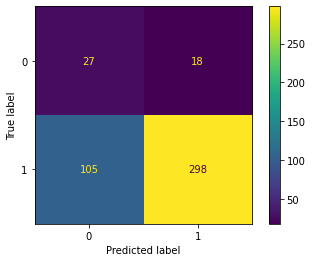

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels= clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

Esta matriz de conclusión nos aporta una visión sobre los aciertos y los errores que se están cometiendo, siendo el eje Y el que demuestra la realidad y el X las predicciones que hemos realizado.

El color azul nos muestra lo que se ha pagado en realizad pero no en la predicción

El amarillo nos muestra lo pagado en la realidad y en la predicción

El morado claro muestra lo que no se ha pagado ni en la realidad ni en la predicción

El morado oscuro muestra lo no pagado en la realidad pero si en la predicción



**Ejercicios**

Plantear el clasificador de préstamos añadiendo datos de otras tablas de la base de datos, u otros campos de las mismas tablas (edad del cliente, etc).

Otras transformaciones: [Discretización](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-discretization) y utilización de otros clasificadores NB